In [1]:
# Imports

# Standard library
import os
import random
import warnings

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import torchvision.transforms as T

# Image processing
from PIL import Image, ImageOps

# Cloud satellite image generation
import satellite_cloud_generator as scg

# Progress bar
from tqdm import tqdm

# Hugging Face Datasets
from datasets import load_dataset, Dataset

# Machine learning utilities
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
DEVICE = torch.device('cpu')

# Dataset configuration
DATASET_NAME         = 'jbourcier/fgsc23'
IMAGE_COL            = 'image'           # HF column name for images
LABEL_COL            = 'label'           # HF column name for labels
CLASS_COL            = ['class_name']    # HF column name for class names

# Image preprocessing
IMG_SIZE    = (224, 224)
TRANSFORM = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Cloud augmentation severities
CLOUD_MIN_RANGE = (0.00, 0.05)
CLOUD_MAX_RANGE = (0.95, 1.00)
BLUR_RADIUS_RANGE = (0.0, 2.0)
NO_CLOUD_MASKS_RANGE = {"Mild": [1], "Moderate": [1, 2], "Severe": [2]}
CLEAR_THRESHOLD = {"Mild": (0.95, 0.99), "Moderate": (0.5, 0.9), "Severe": (0.2, 0.5)}
SHADOW_MAX_LVL = {"Mild": [0.1, 0.4], "Moderate": [0.4, 0.6], "Severe": [0.6, 0.9]}
SEVERITY_PROBS = {
    "Mild": 0.8,
    "Moderate": 0.15,
    "Severe": 0.05,
}

# Model selection
# MODEL_NAMES = ["resnet18", "efficientnet_b0", "mobilenet_v3_large"] # lightweight models
MODEL_NAMES = ["resnet50", "convnext_tiny", "densenet121"]  # more complex models

# Training hyperparameters
BATCH_SIZE    = 32
NUM_EPOCHS    = 10
LEARNING_RATE = 1e-4
NUM_WORKERS   = 0

In [3]:
# Load Dataset
ds: Dataset = load_dataset(DATASET_NAME, split="train")

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 4080
})


In [4]:
# Mapping integer labels (0–22) to human-readable ship class names from Zhang et al. (2020)
label_map = {
    0:  "Non-ship",
    1:  "Aircraft carrier",
    2: "Submarine",
    3: "Medical ship",
    4: "Combat boat",
    5: "Auxiliary ship",
    6: "Container ship",
    7: "Car carrier",
    8: "Hovercraft",
    9: "Bulk carrier",
    10: "Oil tanker",
    11: "Fishing boat",
    12:  "Destroyer",
    13: "Passenger ship",
    14: "Liquefied gas ship",
    15: "Barge",
    16:  "Landing craft",
    17:  "Frigate",
    18:  "Amphibious transport dock",
    19:  "Cruiser",
    20:  "Tarawa-class amphibious assault ship",
    21:  "Amphibious assault ship",
    22:  "Command ship",
}

# Add a new column 'class_name' to the dataset with human-readable labels
def map_label(example):
    example['class_name'] = label_map.get(example['label'], "Unknown")
    return example

ds = ds.map(map_label)

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label', 'class_name'],
    num_rows: 4080
})


Class distribution (sorted):
class_name
Destroyer                               542
Non-ship                                484
Bulk carrier                            343
Frigate                                 295
Cruiser                                 293
Submarine                               238
Auxiliary ship                          225
Aircraft carrier                        166
Oil tanker                              165
Amphibious assault ship                 154
Combat boat                             143
Hovercraft                              120
Landing craft                           108
Fishing boat                            102
Container ship                          100
Liquefied gas ship                       94
Amphibious transport dock                90
Command ship                             89
Tarawa-class amphibious assault ship     88
Passenger ship                           88
Car carrier                              72
Barge                               

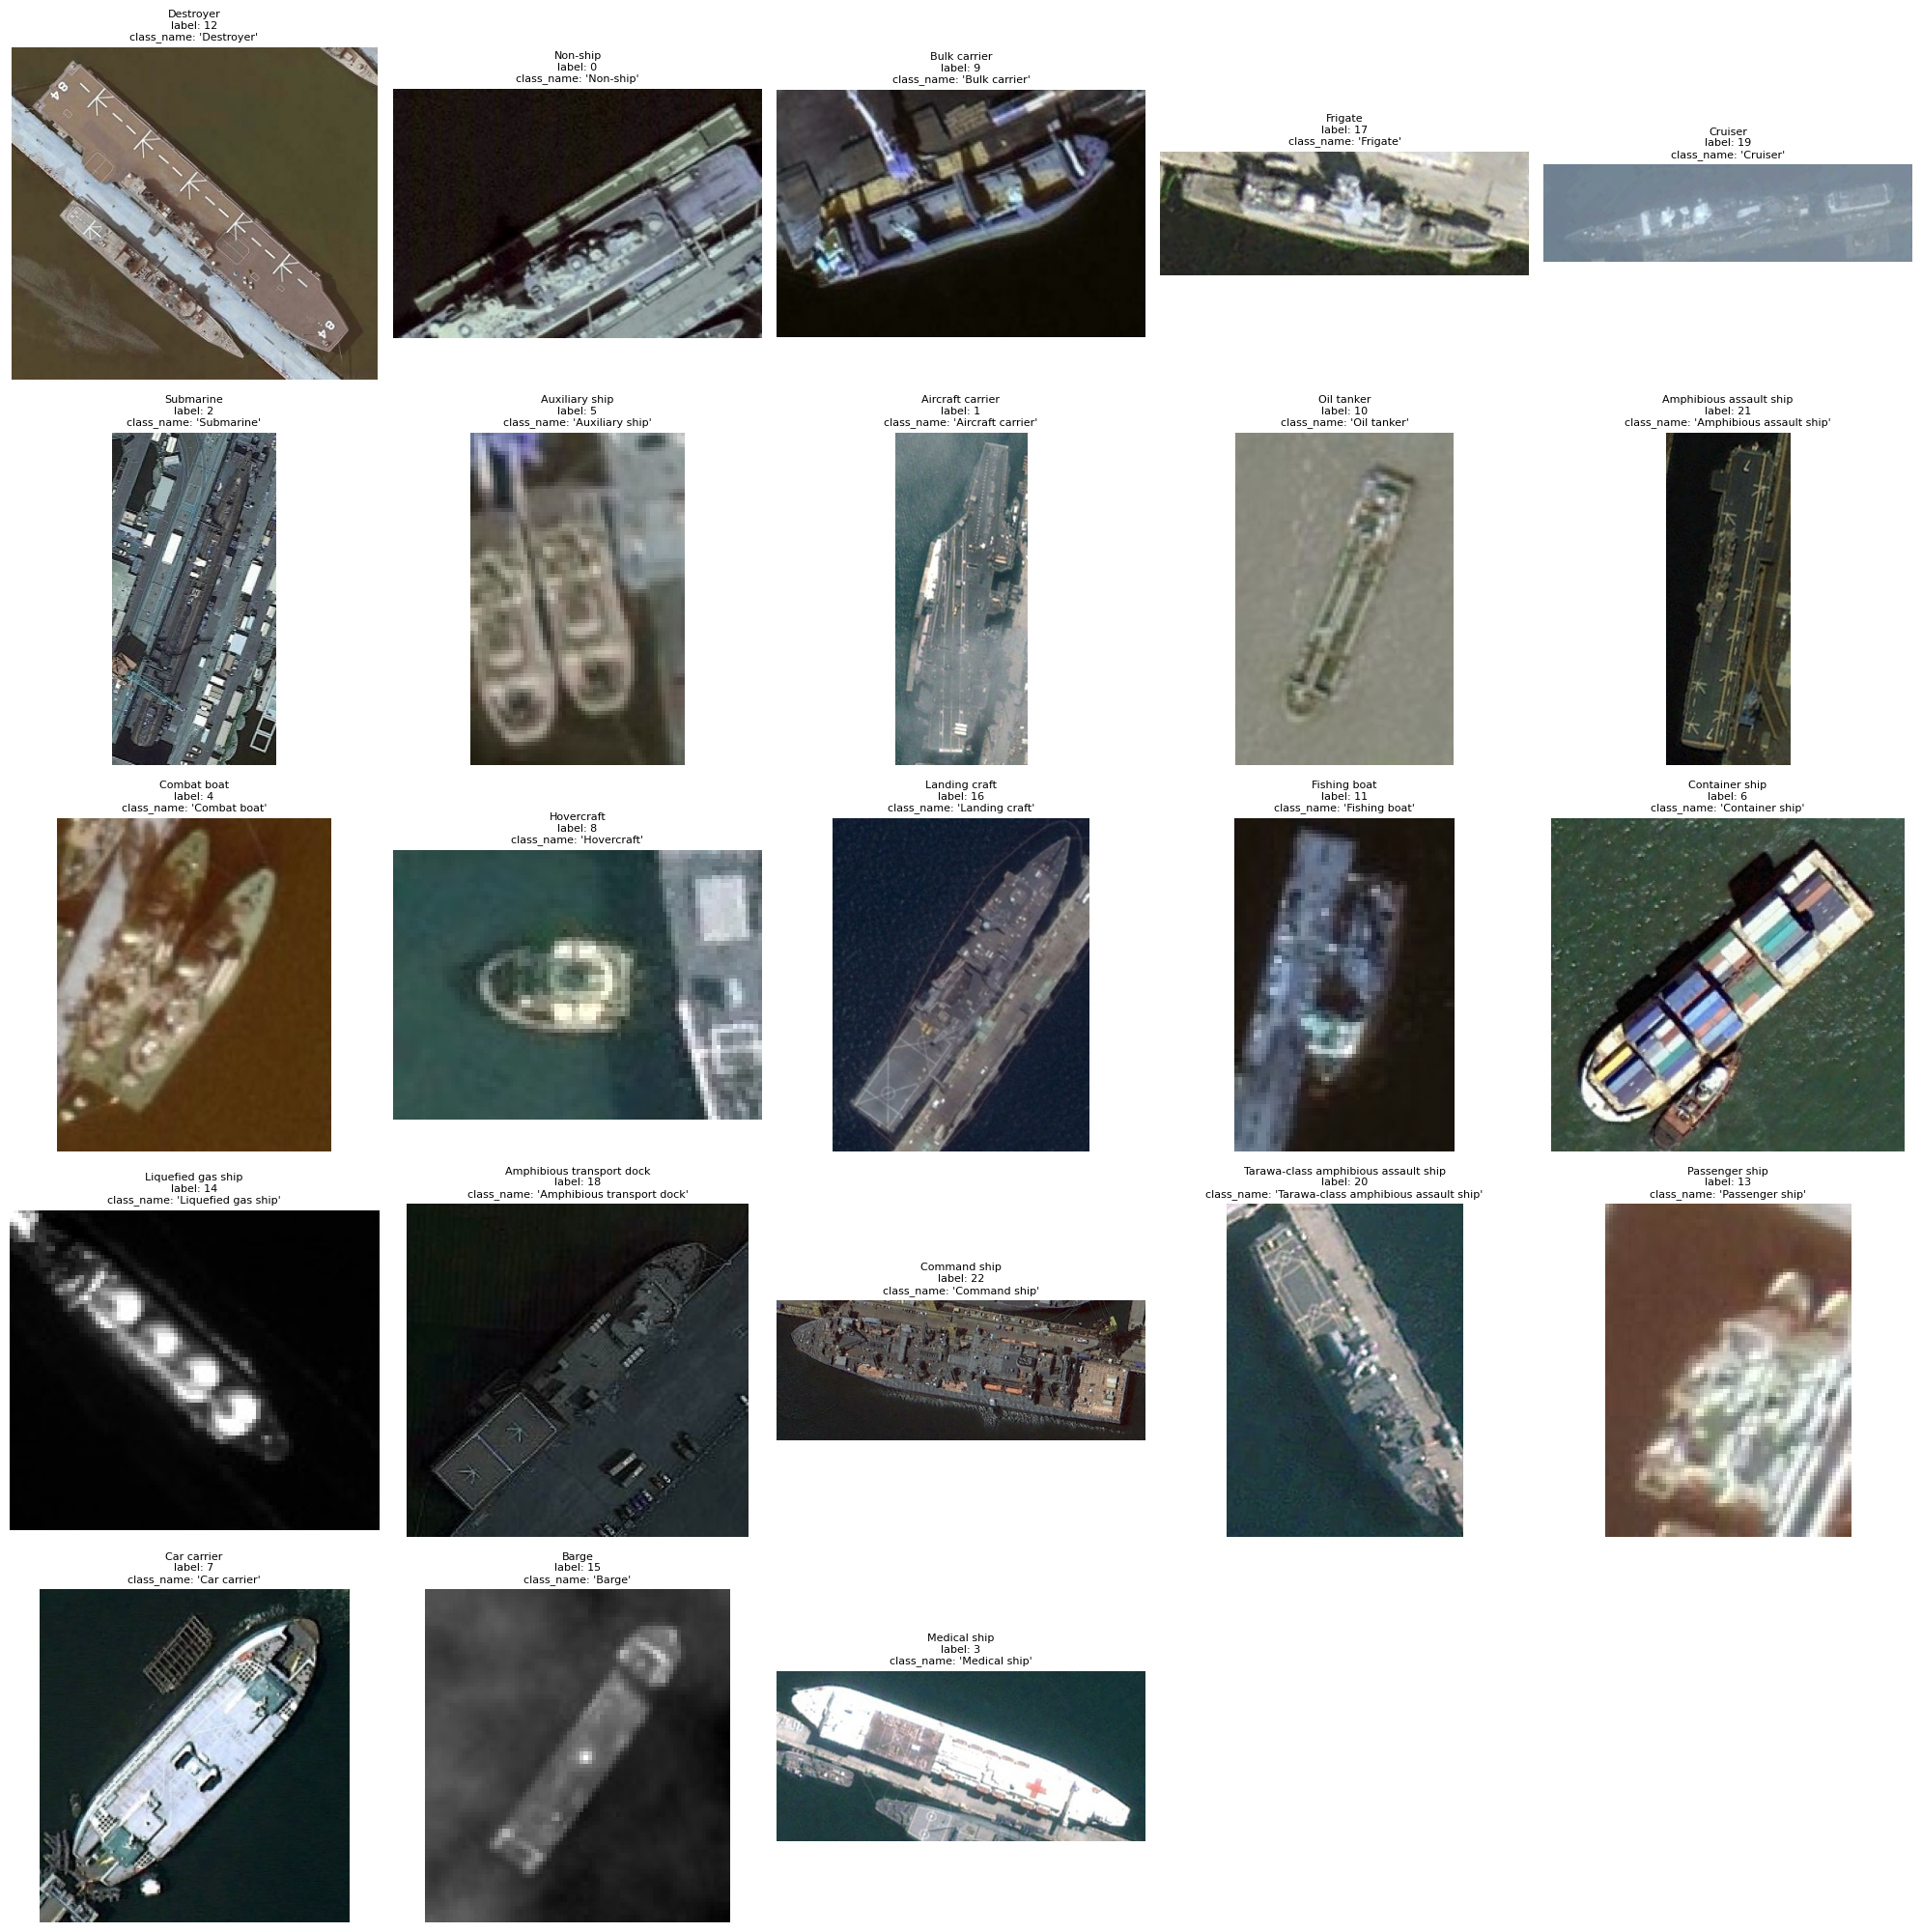

In [5]:
# Inspect Dataset

# Print class distribution sorted by sample count
class_counts = ds.to_pandas()['class_name'].value_counts().sort_values(ascending=False)
print("Class distribution (sorted):")
print(class_counts)

def plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5):
    """
    Plots one image per class in a grid, with all features printed above each image.

    Args:
        ds: Dataset object.
        class_counts: Pandas Series of class counts, sorted.
        n_rows: Number of rows in grid.
        n_cols: Number of columns in grid.
    """
    n_classes = len(class_counts)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    for i, class_name in enumerate(class_counts.index):
        row, col = divmod(i, n_cols)
        ax = axes[row, col]
        idx = int(ds.to_pandas().query("class_name == @class_name").index[0])
        example = ds[idx]
        img = example['image']

        # Prepare feature string
        feature_str = "\n".join([f'{k}: {repr(v)}' for k, v in example.items() if k != 'image'])

        ax.imshow(img)
        ax.set_title(f"{class_name}\n{feature_str}", fontsize=8)
        ax.axis('off')

    # Hide unused subplots if any
    for j in range(n_classes, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

In [6]:
def calculate_combined_cloud_coverage(masks):
    """
    Calculate cloud coverage from multiple overlapping cloud masks, 
    respecting transparency levels.
    
    Args:
        masks (List[Tensor]): List of cloud masks, each tensor shape [B,C,H,W], values between 0 (transparent) and 1 (opaque).
        
    Returns:
        float or Tensor: combined cloud coverage score between 0 (no coverage) and 1 (full coverage).
    """
    # Start with full transparency (no clouds)
    combined_transparency = torch.ones_like(masks[0])

    # Multiply transparency factors of all masks
    for mask in masks:
        combined_transparency *= (1 - mask)
    
    # Convert transparency back to opacity
    combined_opacity = 1 - combined_transparency

    # Calculate mean cloud coverage score over all pixels
    coverage = combined_opacity.mean(dim=[1, 2, 3])
    return coverage.item() if coverage.numel() == 1 else coverage

Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4080 [00:00<?, ? examples/s]

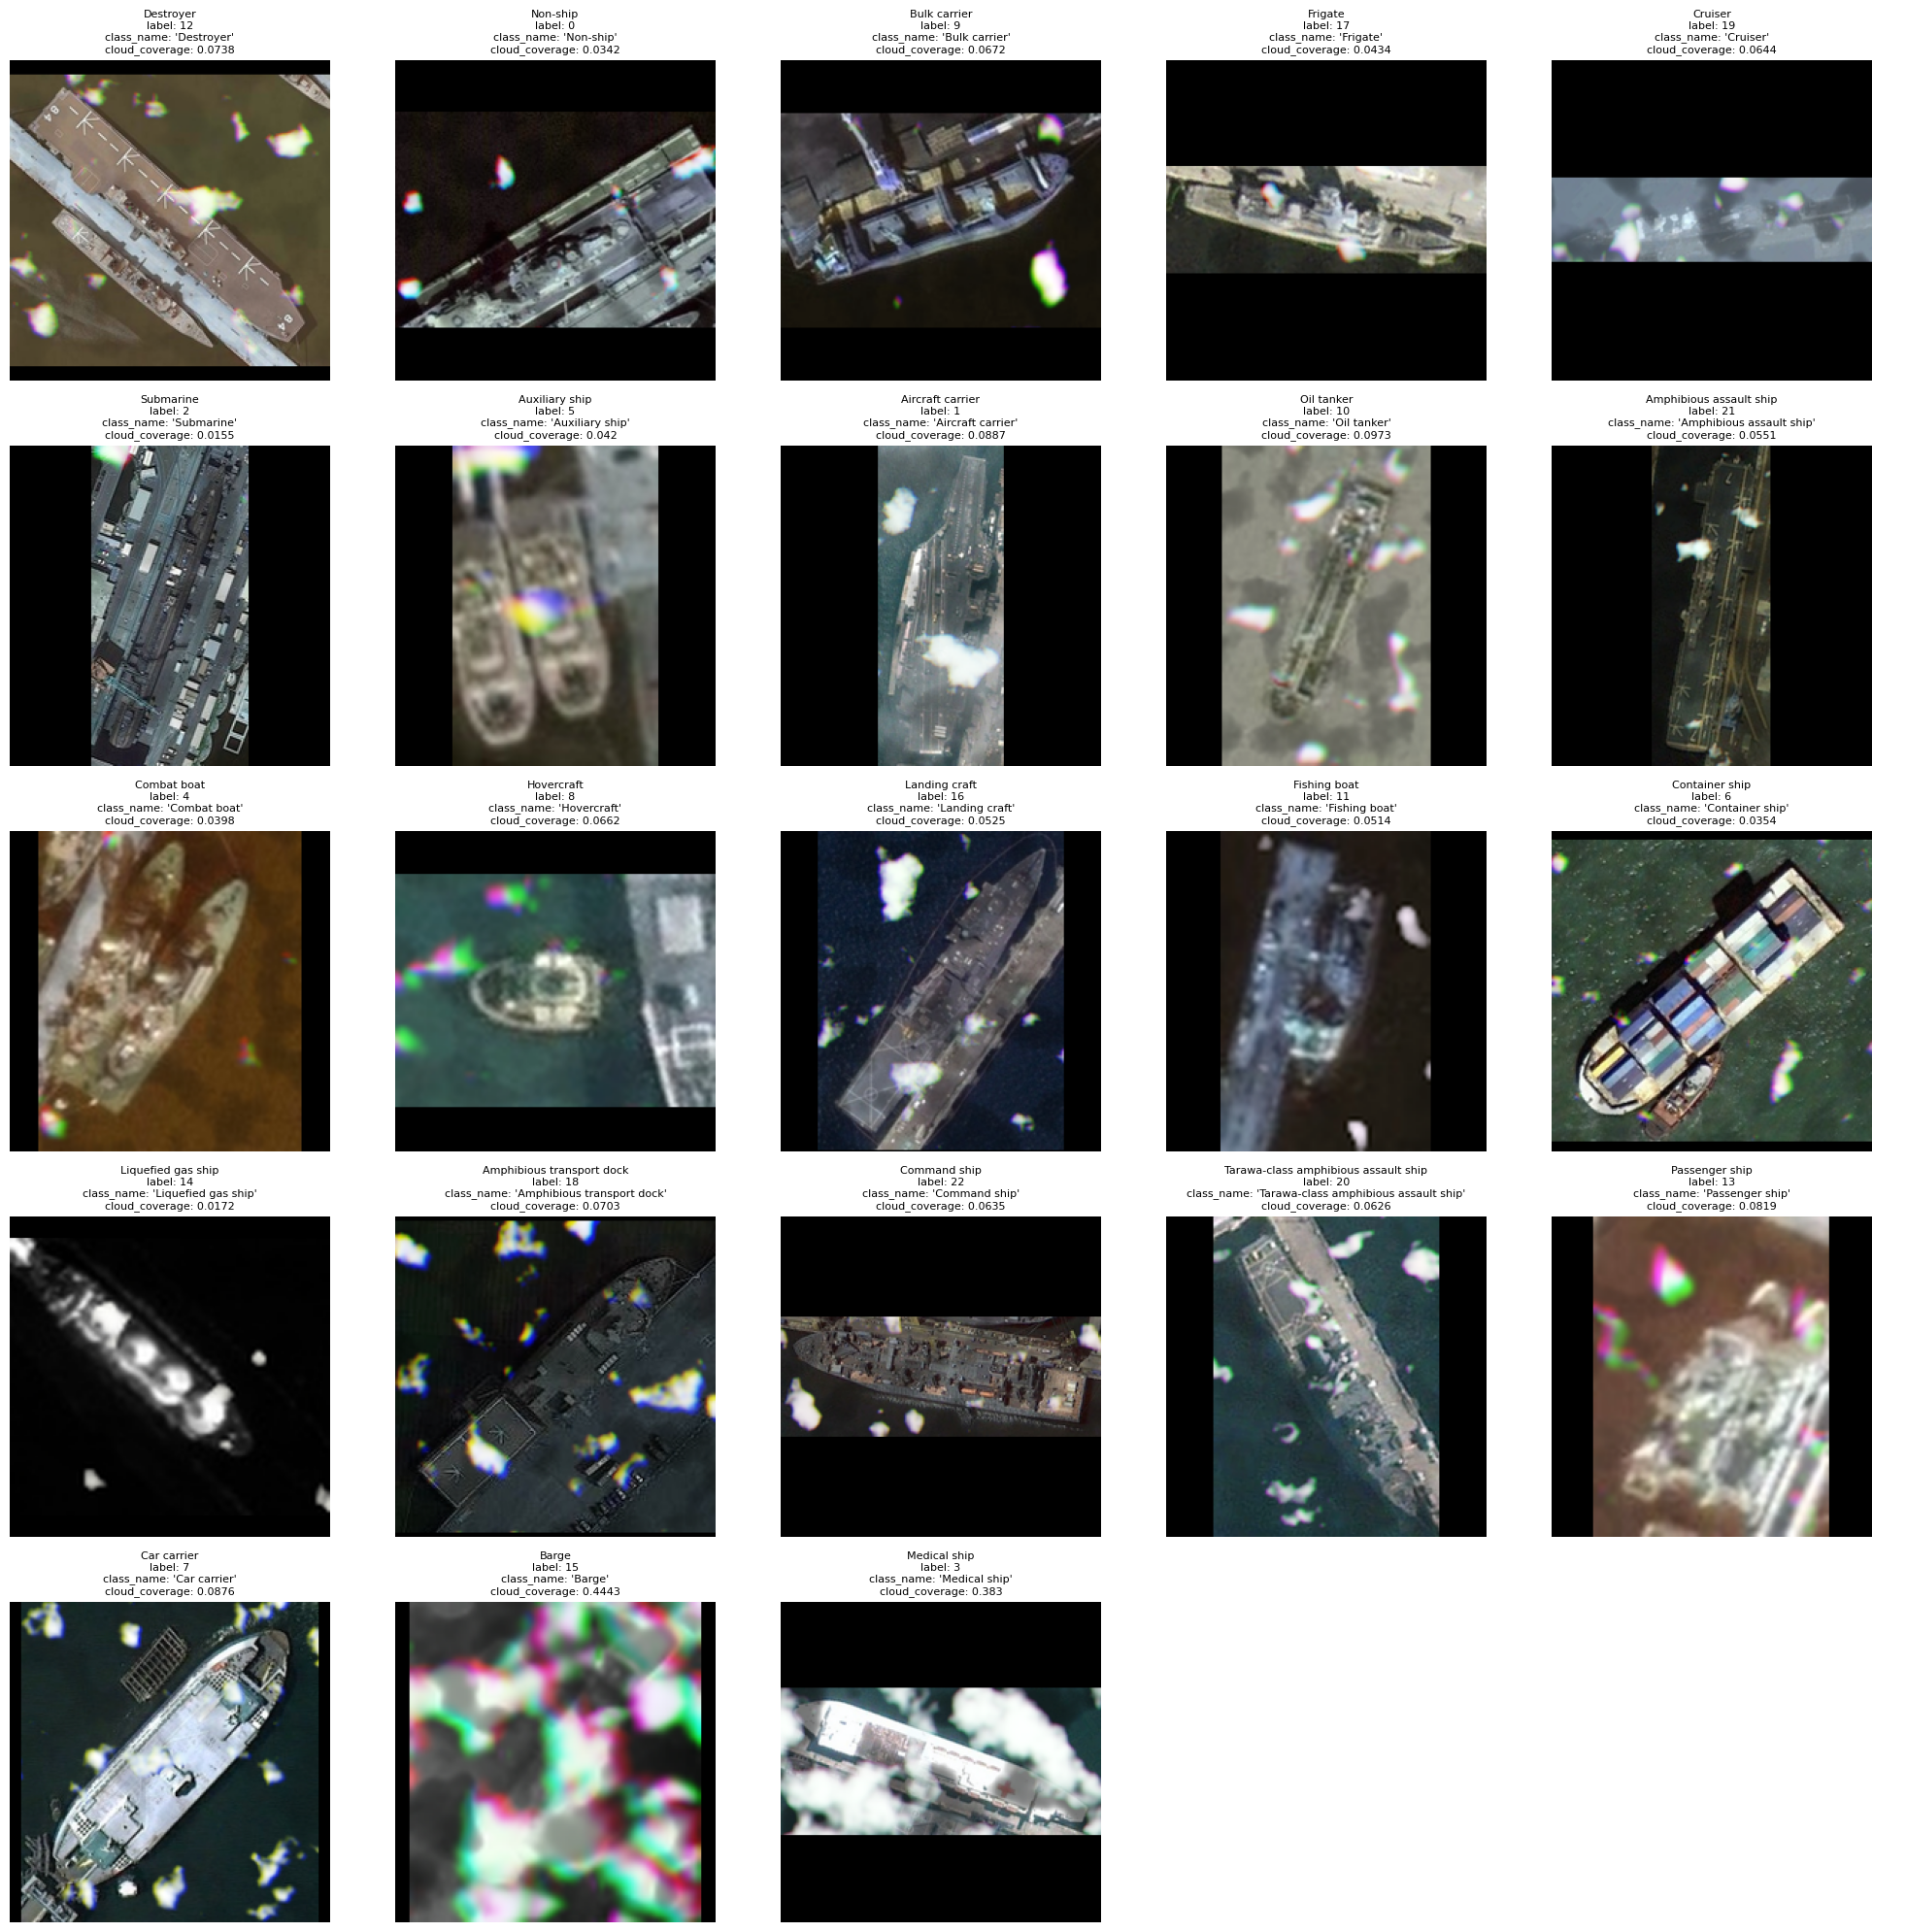

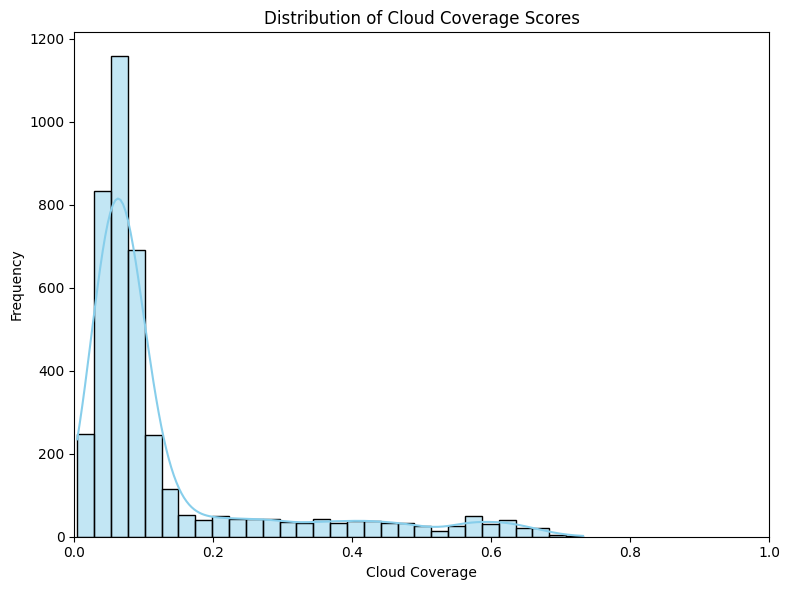

In [7]:
def preprocess(example):
    # Load and ensure RGB
    img = example["image"].convert("RGB")

    # Convert to tensor
    img_tensor = transforms.ToTensor()(img).unsqueeze(0)

    # Select cloud severity based on probability
    severity = random.choices(
        population=list(SEVERITY_PROBS.keys()),
        weights=list(SEVERITY_PROBS.values()),
        k=1
    )[0]

    # Determine the number of cloud masks
    num_cloud_masks = random.choice(NO_CLOUD_MASKS_RANGE[severity])

    cloud_masks = []
    blur_radius = random.uniform(*BLUR_RADIUS_RANGE)

    # Apply cloud masks
    for _ in range(num_cloud_masks):
        img_tensor, cloud_mask, _ = scg.add_cloud_and_shadow(
            img_tensor,
            max_lvl=CLOUD_MAX_RANGE,
            min_lvl=CLOUD_MIN_RANGE,
            shadow_max_lvl=SHADOW_MAX_LVL[severity],
            clear_threshold=CLEAR_THRESHOLD[severity],
            noise_type="perlin",
            const_scale=True,
            decay_factor=1,
            locality_degree=1,
            channel_offset=2,
            channel_magnitude_shift=0.05,
            blur_scaling=blur_radius,
            cloud_color=True,
            return_cloud=True
        )
        cloud_masks.append(cloud_mask)

    # Calculate combined cloud coverage
    cloud_coverage = calculate_combined_cloud_coverage(cloud_masks)

    # Convert back to PIL image
    augmented_img = transforms.ToPILImage()(img_tensor.squeeze(0))

    # Resize image
    iw, ih = augmented_img.size
    tw, th = IMG_SIZE
    scale = min(tw / iw, th / ih)
    nw, nh = int(iw * scale), int(ih * scale)
    img_resized = augmented_img.resize((nw, nh), Image.LANCZOS)

    # Pad image
    pad_left = (tw - nw) // 2
    pad_top = (th - nh) // 2
    pad_right = tw - nw - pad_left
    pad_bottom = th - nh - pad_top
    img_padded = ImageOps.expand(
        img_resized,
        border=(pad_left, pad_top, pad_right, pad_bottom),
        fill=(0, 0, 0)
    )

    # Overwrite and save parameters
    example["image"] = img_padded
    example["cloud_coverage"] = round(cloud_coverage, 4)

    return example

# Apply to dataset
ds = ds.map(preprocess, batched=False)

# Persist to disk in Arrow+image format
ds.save_to_disk("data/preprocessed_dataset/")

# Save metadata
metadata_df = ds.to_pandas()[["label", "class_name", "cloud_coverage"]]
metadata_path = os.path.join("data", "preprocessed_metadata.csv")
metadata_df.to_csv(metadata_path, index=False)

# Plot one image per class
plot_one_image_per_class(ds, class_counts, n_rows=5, n_cols=5)

# Plot histogram of cloud coverage scores
coverage_values = ds.to_pandas()['cloud_coverage']
plt.figure(figsize=(8, 6))
sns.histplot(coverage_values, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Cloud Coverage Scores')
plt.xlabel('Cloud Coverage')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("results/cloud_coverage_distribution_dataset.svg", format="svg")
plt.show()

Saving the dataset (0/1 shards):   0%|          | 0/2448 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/816 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/816 [00:00<?, ? examples/s]

Train set size: 2448
Validation set size: 816
Test set size: 816


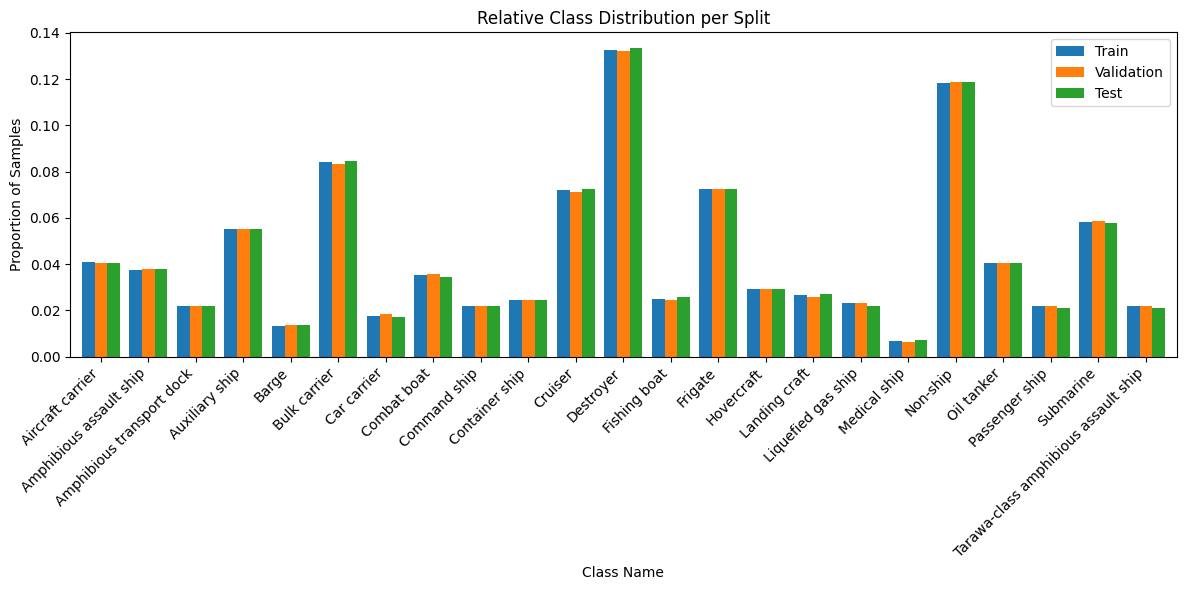

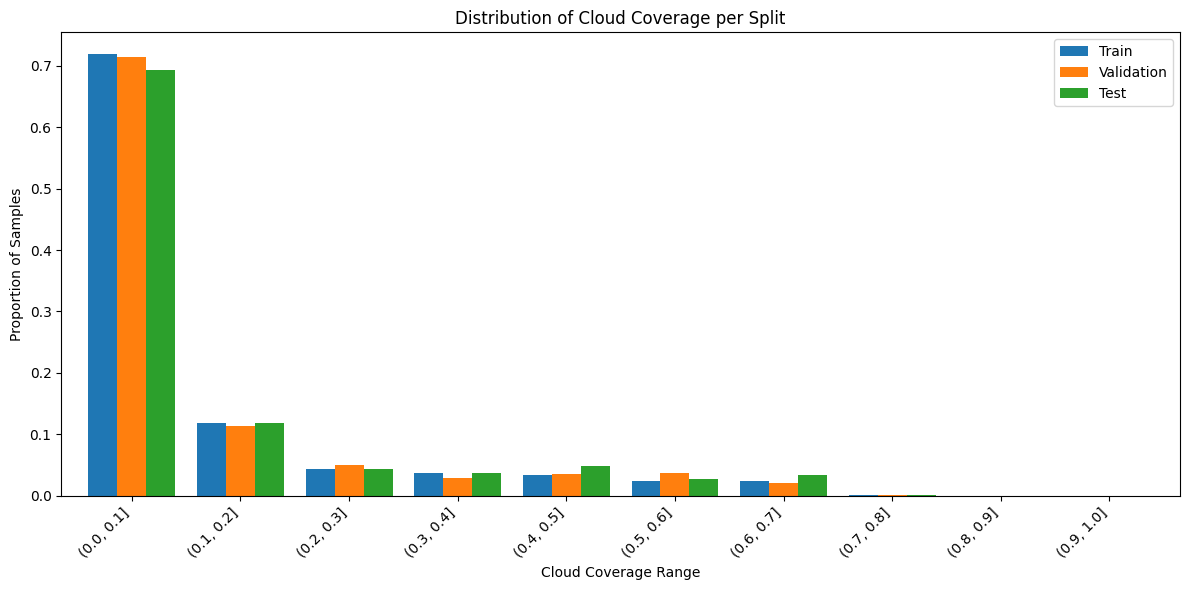

In [8]:
# Define split ratios for sufficient calibration and testing
val_ratio = 0.2
test_ratio = 0.2

# Get labels array for stratification
labels = ds.to_pandas()['label'].values

# First stratified split: train vs. (val+test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio))
train_idx, temp_idx = next(sss.split(np.zeros(len(labels)), labels))

# Second stratified split: within the temp set, separate val and test
temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=test_ratio / (val_ratio + test_ratio),
)
val_sub_idx, test_sub_idx = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))
val_idx = temp_idx[val_sub_idx]
test_idx = temp_idx[test_sub_idx]

# Create and save splits
ds_train = ds.select(train_idx)
ds_val   = ds.select(val_idx)
ds_test  = ds.select(test_idx)

ds_train.save_to_disk("data/train_dataset/")
ds_val.save_to_disk("data/val_dataset/")
ds_test.save_to_disk("data/test_dataset/")

# Print split sizes
print(f"Train set size: {len(ds_train)}")
print(f"Validation set size: {len(ds_val)}")
print(f"Test set size: {len(ds_test)}")

# Compute relative class distributions for each split
dist_train = ds_train.to_pandas()['class_name'].value_counts(normalize=True).sort_index()
dist_val   = ds_val.to_pandas()['class_name'].value_counts(normalize=True).sort_index()
dist_test  = ds_test.to_pandas()['class_name'].value_counts(normalize=True).sort_index()

# Combine into a single DataFrame
dist_df = pd.DataFrame({
    'Train': dist_train,
    'Validation': dist_val,
    'Test': dist_test
}).fillna(0)

# Plot grouped bar chart of relative frequencies
ax = dist_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8
)
ax.set_xlabel('Class Name')
ax.set_ylabel('Proportion of Samples')
ax.set_title('Relative Class Distribution per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('results', 'relative_class_dist.svg'), format='svg')
plt.show()

# Plot distribution of image quality scores per split
# Bin quality scores into deciles
bins = np.linspace(0, 1, 11)
q_train = pd.cut(ds_train.to_pandas()['cloud_coverage'], bins=bins)
q_val   = pd.cut(ds_val.to_pandas()['cloud_coverage'], bins=bins)
q_test  = pd.cut(ds_test.to_pandas()['cloud_coverage'], bins=bins)

dist_q_train = q_train.value_counts(normalize=True).sort_index()
dist_q_val   = q_val.value_counts(normalize=True).sort_index()
dist_q_test  = q_test.value_counts(normalize=True).sort_index()

dist_q_df = pd.DataFrame({
    'Train': dist_q_train,
    'Validation': dist_q_val,
    'Test': dist_q_test
}).fillna(0)

ax = dist_q_df.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8
)
ax.set_xlabel('Cloud Coverage Range')
ax.set_ylabel('Proportion of Samples')
ax.set_title('Distribution of Cloud Coverage per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('results', 'cloud_coverage_distribution_splits.svg'), format='svg')
plt.show()

In [9]:
# DataLoaders
# No transform is applied here, as the images are already preprocessed and we would need new quality scores for any new images.
# Define a custom collate function to handle the dataset format

def collate_fn(batch):
    imgs = [TRANSFORM(ex["image"].convert("RGB")) for ex in batch]
    labels = [ex["label"] for ex in batch]
    imgs = torch.stack(imgs).to(DEVICE)
    labels = torch.tensor(labels, dtype=torch.long, device=DEVICE)
    return imgs, labels

# compute class frequencies on the training set
train_labels = ds_train.to_pandas()['label'].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts

# assign each sample its class weight
sample_weights = class_weights[train_labels]
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
train_loader = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    ds_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Validation: {len(val_loader)}, Test: {len(test_loader)}")

Train batches: 77, Validation: 26, Test: 26


In [10]:
# Function to get model and prepare it for classification depending on the number of classes

def get_model(name, num_classes):
    if name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

    elif name == "densenet121":
        # Dense connectivity—and a single Linear classifier head
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif name == "convnext_tiny":
        # ConvNeXt Tiny: classifier is a nn.Sequential([Flatten, LayerNorm, Linear])
        model = models.convnext_tiny(pretrained=True)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

    else:
        raise ValueError(f"Unknown model: {name}")

    return model



=== Training resnet50 on cpu ===


Epoch 1/10 - resnet50 val_acc: 0.4792


Epoch 2/10 - resnet50 val_acc: 0.6176


Epoch 3/10 - resnet50 val_acc: 0.6385


Epoch 4/10 - resnet50 val_acc: 0.6458


Epoch 5/10 - resnet50 val_acc: 0.6875


Epoch 6/10 - resnet50 val_acc: 0.6520


Epoch 7/10 - resnet50 val_acc: 0.6029


Epoch 8/10 - resnet50 val_acc: 0.6238


Epoch 9/10 - resnet50 val_acc: 0.6752


Epoch 10/10 - resnet50 val_acc: 0.6397
Saved best resnet50 (val_acc=0.6875) to models\best_resnet50_epoch0.6875.pth


Test accuracy for resnet50: 0.6458
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        97
           1       0.80      0.61      0.69        33
           2       0.71      0.74      0.73        47
           3       0.50      0.83      0.62         6
           4       0.80      0.43      0.56        28
           5       0.36      0.69      0.47        45
           6       1.00      0.75      0.86        20
           7       0.88      0.50      0.64        14
           8       0.80      1.00      0.89        24
           9       0.73      0.39      0.51        69
          10       0.67      0.30      0.42        33
          11       0.31      0.43      0.36        21
          12       0.70      0.84      0.76       109
          13       0.86      0.35      0.50        17
          14       0.95      1.00      0.97        18
          15       0.71      0.91      0.80        11
          16       0.80      0.55      0.65   

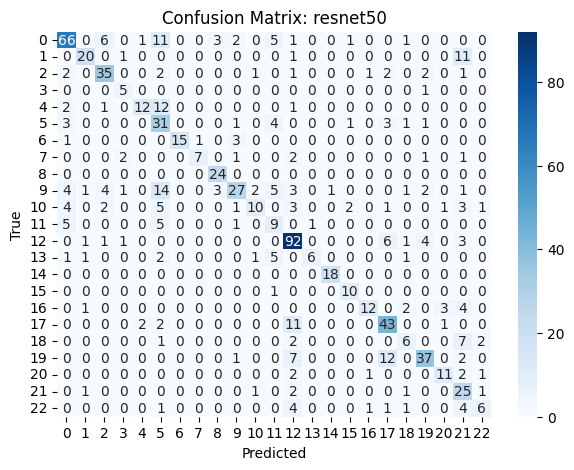


=== Training convnext_tiny on cpu ===
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\gianl/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:06<00:00, 16.8MB/s] 


Epoch 1/10 - convnext_tiny val_acc: 0.5637


Epoch 2/10 - convnext_tiny val_acc: 0.7071


Epoch 3/10 - convnext_tiny val_acc: 0.7488


Epoch 4/10 - convnext_tiny val_acc: 0.7549


Epoch 5/10 - convnext_tiny val_acc: 0.7721


Epoch 6/10 - convnext_tiny val_acc: 0.7696


Epoch 7/10 - convnext_tiny val_acc: 0.7708


Epoch 8/10 - convnext_tiny val_acc: 0.7586


Epoch 9/10 - convnext_tiny val_acc: 0.7512


Epoch 10/10 - convnext_tiny val_acc: 0.7525
Saved best convnext_tiny (val_acc=0.7721) to models\best_convnext_tiny_epoch0.7721.pth


Test accuracy for convnext_tiny: 0.7316
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        97
           1       0.89      0.94      0.91        33
           2       0.80      0.74      0.77        47
           3       1.00      0.83      0.91         6
           4       0.61      0.79      0.69        28
           5       0.45      0.53      0.49        45
           6       0.63      0.85      0.72        20
           7       0.83      0.71      0.77        14
           8       0.80      1.00      0.89        24
           9       0.66      0.48      0.55        69
          10       0.81      0.67      0.73        33
          11       0.41      0.67      0.51        21
          12       0.78      0.86      0.82       109
          13       0.41      0.53      0.46        17
          14       1.00      1.00      1.00        18
          15       1.00      0.73      0.84        11
          16       0.78      0.82      0.

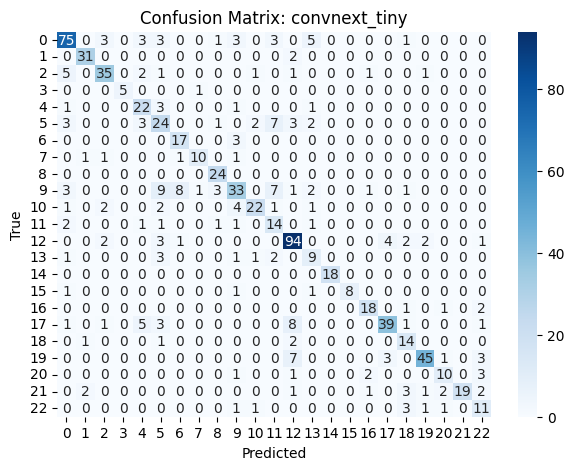


=== Training densenet121 on cpu ===


Epoch 1/10 - densenet121 val_acc: 0.4289


Epoch 2/10 - densenet121 val_acc: 0.5748


Epoch 3/10 - densenet121 val_acc: 0.6556


Epoch 4/10 - densenet121 val_acc: 0.6703


Epoch 5/10 - densenet121 val_acc: 0.6777


Epoch 6/10 - densenet121 val_acc: 0.7059


Epoch 7/10 - densenet121 val_acc: 0.7022


Epoch 8/10 - densenet121 val_acc: 0.6998


Epoch 9/10 - densenet121 val_acc: 0.7071


Epoch 10/10 - densenet121 val_acc: 0.7034
Saved best densenet121 (val_acc=0.7071) to models\best_densenet121_epoch0.7071.pth


Test accuracy for densenet121: 0.7108
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        97
           1       0.76      0.85      0.80        33
           2       0.82      0.77      0.79        47
           3       1.00      0.33      0.50         6
           4       0.40      0.68      0.51        28
           5       0.47      0.44      0.45        45
           6       0.94      0.75      0.83        20
           7       1.00      0.71      0.83        14
           8       0.92      0.92      0.92        24
           9       0.72      0.59      0.65        69
          10       0.64      0.64      0.64        33
          11       0.48      0.62      0.54        21
          12       0.74      0.79      0.76       109
          13       0.86      0.35      0.50        17
          14       1.00      1.00      1.00        18
          15       0.91      0.91      0.91        11
          16       0.67      0.73      0.70

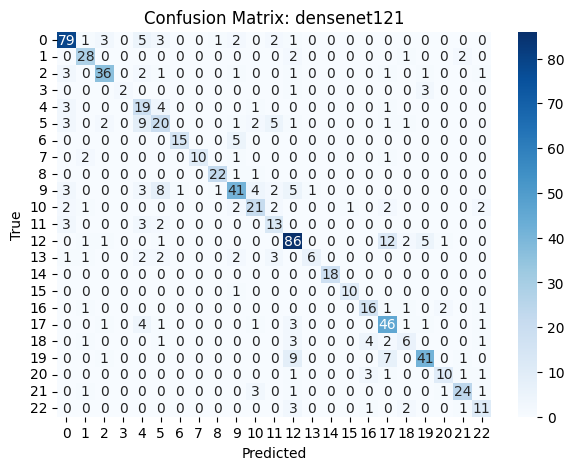


=== Summary of All Models ===
resnet50: val_acc=0.6875, test_acc=0.6458, model saved at models\best_resnet50_epoch0.6875.pth
convnext_tiny: val_acc=0.7721, test_acc=0.7316, model saved at models\best_convnext_tiny_epoch0.7721.pth
densenet121: val_acc=0.7071, test_acc=0.7108, model saved at models\best_densenet121_epoch0.7071.pth


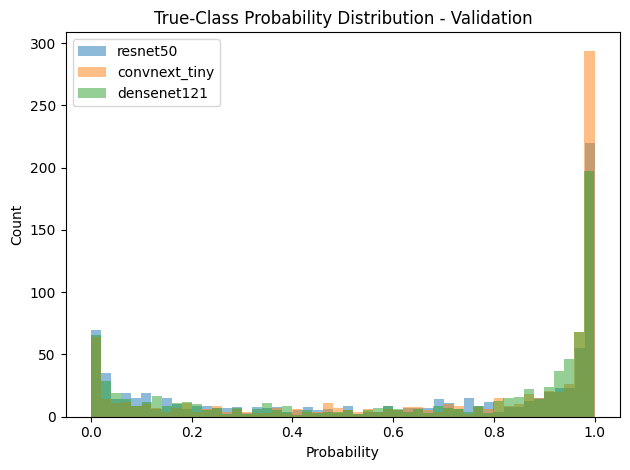

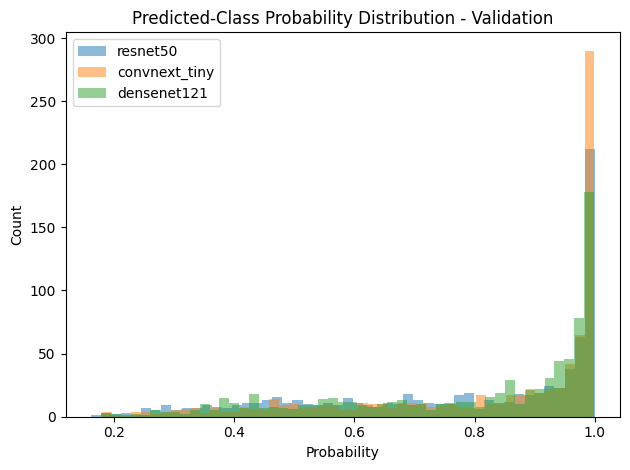

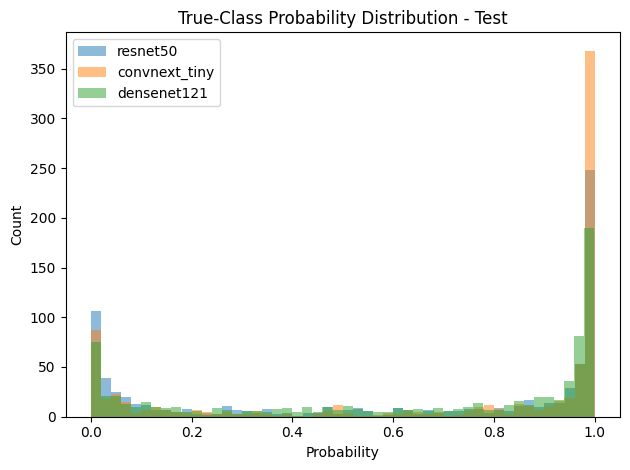

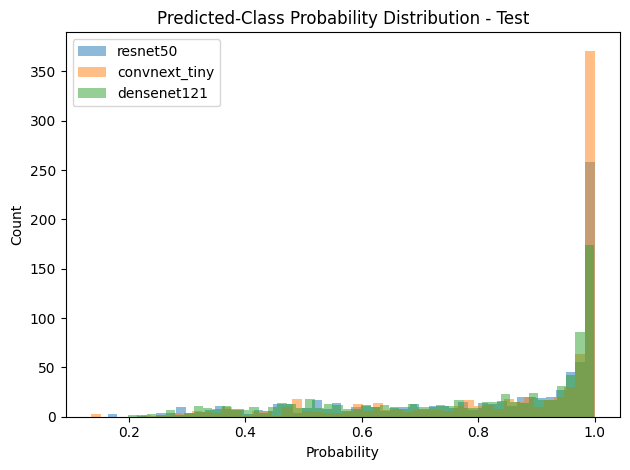

In [11]:
# Data loaders (assumed defined elsewhere): train_loader, val_loader, test_loader
# label_map defined previously; determines num_classes
num_classes = len(label_map)

# To store per-model summaries and probability distributions
history = {}
prob_dists = {}

for name in MODEL_NAMES:
    print(f"\n=== Training {name} on {DEVICE} ===")
    model = get_model(name, num_classes).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    best_epoch_acc = 0.0
    best_state = None
    val_records = {'preds': [], 'labels': [], 'probs': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # Training
        model.train()
        train_iter = tqdm(train_loader, desc=f"[{name}] Train Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        for imgs, labels in train_iter:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_iter = tqdm(val_loader, desc=f"[{name}] Val Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        all_preds, all_labels, all_probs = [], [], []
        with torch.no_grad():
            for imgs, labels in val_iter:
                imgs = imgs.to(DEVICE)
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.tolist())
                all_probs.extend(probs.cpu().tolist())

        val_acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch}/{NUM_EPOCHS} - {name} val_acc: {val_acc:.4f}")

        # If best for this model, save state
        if val_acc > best_epoch_acc:
            best_epoch_acc = val_acc
            best_state = model.state_dict()
            val_records = {'preds': all_preds, 'labels': all_labels, 'probs': all_probs}

    # Save best model
    model_filename = f"best_{name}_epoch{best_epoch_acc:.4f}.pth"
    model_path = os.path.join('models', model_filename)
    torch.save(best_state, model_path)
    print(f"Saved best {name} (val_acc={best_epoch_acc:.4f}) to {model_path}")

    # Test with best weights
    model.load_state_dict(best_state)
    model.eval()
    test_preds, test_labels, test_probs = [], [], []
    test_iter = tqdm(test_loader, desc=f"[{name}] Testing", leave=False)
    with torch.no_grad():
        for imgs, labels in test_iter:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(labels.tolist())
            test_probs.extend(probs.cpu().tolist())

    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Test accuracy for {name}: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds))

    # Plot and save confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join('results', f'confusion_matrix_{name}.svg'), format='svg')
    plt.show()

    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())
    cm_csv = os.path.join('results', f"confusion_matrix_{name}.csv")
    cm_df.to_csv(cm_csv, index=True)

    # Save class probabilities + predictions
    cols = [f"prob_{i}" for i in range(num_classes)]
    val_df = pd.DataFrame(val_records['probs'], columns=cols)
    val_df['true'] = val_records['labels']
    val_df['pred'] = val_records['preds']
    val_csv = os.path.join('results', f"val_{name}_class_probs.csv")
    val_df.to_csv(val_csv, index=False)

    test_df = pd.DataFrame(test_probs, columns=cols)
    test_df['true'] = test_labels
    test_df['pred'] = test_preds
    test_csv = os.path.join('results', f"test_{name}_class_probs.csv")
    test_df.to_csv(test_csv, index=False)

    # Compute true-class and predicted-class probability distributions
    true_prob_val = [val_records['probs'][i][label] for i, label in enumerate(val_records['labels'])]
    pred_prob_val = [max(probs) for probs in val_records['probs']]
    true_prob_test = [test_probs[i][label] for i, label in enumerate(test_labels)]
    pred_prob_test = [max(probs) for probs in test_probs]
    prob_dists[name] = {
        'val_true': true_prob_val,
        'val_pred': pred_prob_val,
        'test_true': true_prob_test,
        'test_pred': pred_prob_test
    }

    # Record summary
    history[name] = {
        'best_val_acc': best_epoch_acc,
        'best_model_file': model_path,
        'test_acc': test_acc,
        'val_probs_csv': val_csv,
        'test_probs_csv': test_csv
    }

# Summarize all models
print("\n=== Summary of All Models ===")
for name, stats in history.items():
    print(f"{name}: val_acc={stats['best_val_acc']:.4f}, test_acc={stats['test_acc']:.4f}, model saved at {stats['best_model_file']}")

# Plot and save separate histograms
# Validation true-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['val_true'], bins=50, alpha=0.5, label=name)
plt.title('True-Class Probability Distribution - Validation')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'val_true_prob_dist.svg'), format='svg')
plt.show()

# Validation predicted-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['val_pred'], bins=50, alpha=0.5, label=name)
plt.title('Predicted-Class Probability Distribution - Validation')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'val_pred_prob_dist.svg'), format='svg')
plt.show()

# Test true-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['test_true'], bins=50, alpha=0.5, label=name)
plt.title('True-Class Probability Distribution - Test')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'test_true_prob_dist.svg'), format='svg')
plt.show()

# Test predicted-class probabilities
plt.figure()
for name, d in prob_dists.items():
    plt.hist(d['test_pred'], bins=50, alpha=0.5, label=name)
plt.title('Predicted-Class Probability Distribution - Test')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results','test_pred_prob_dist.svg'), format='svg')
plt.show()

resnet50 VAL - Correct: avg pred_prob=0.8481, avg cloud_coverage=0.1004
resnet50 VAL - Incorrect: avg pred_prob=0.6134, avg cloud_coverage=0.1982


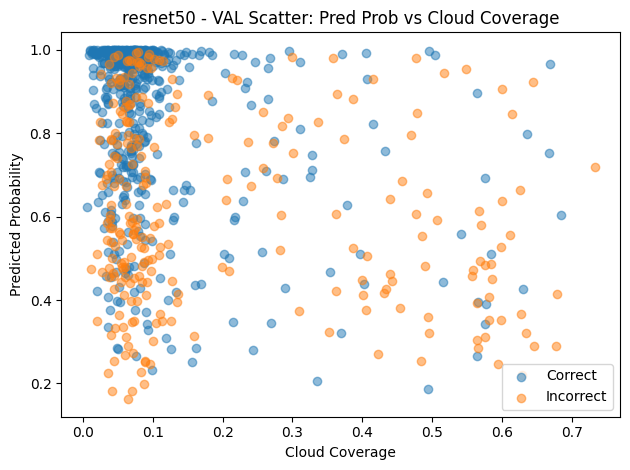

convnext_tiny VAL - Correct: avg pred_prob=0.8806, avg cloud_coverage=0.1084
convnext_tiny VAL - Incorrect: avg pred_prob=0.6431, avg cloud_coverage=0.2073


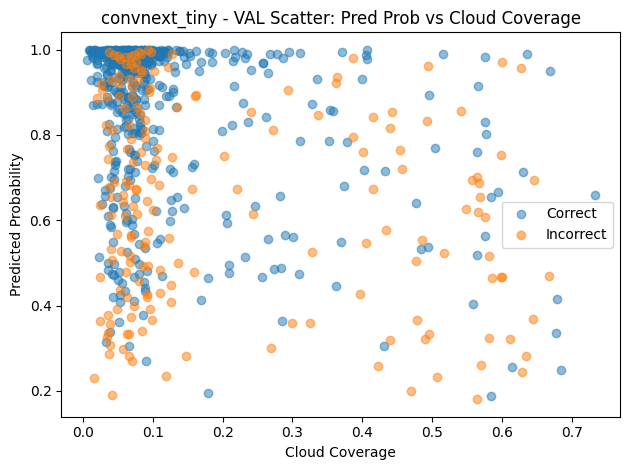

densenet121 VAL - Correct: avg pred_prob=0.8660, avg cloud_coverage=0.1047
densenet121 VAL - Incorrect: avg pred_prob=0.6140, avg cloud_coverage=0.1943


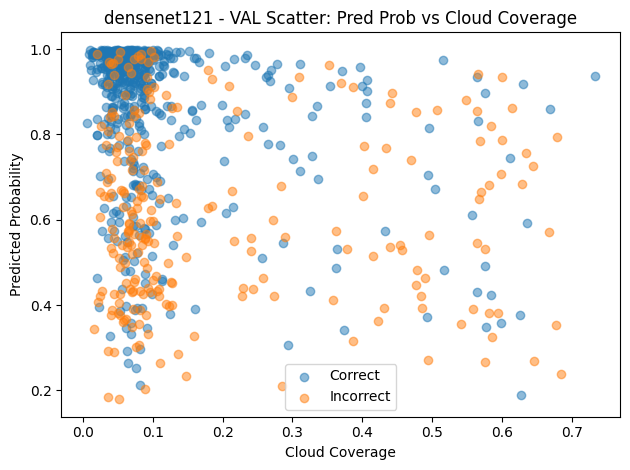

resnet50 TEST - Correct: avg pred_prob=0.8832, avg cloud_coverage=0.1042
resnet50 TEST - Incorrect: avg pred_prob=0.6649, avg cloud_coverage=0.1997


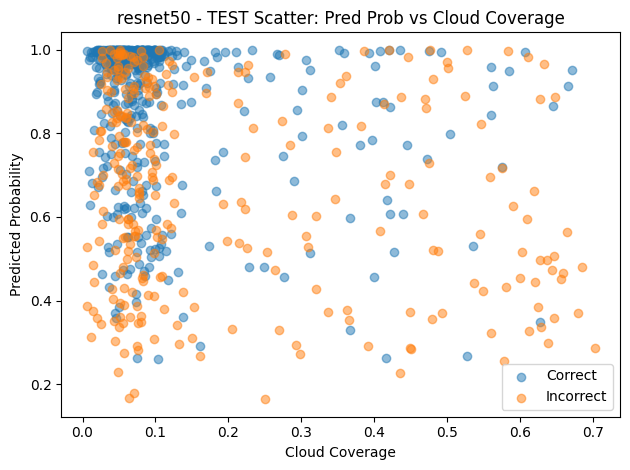

convnext_tiny TEST - Correct: avg pred_prob=0.9243, avg cloud_coverage=0.1053
convnext_tiny TEST - Incorrect: avg pred_prob=0.6648, avg cloud_coverage=0.2273


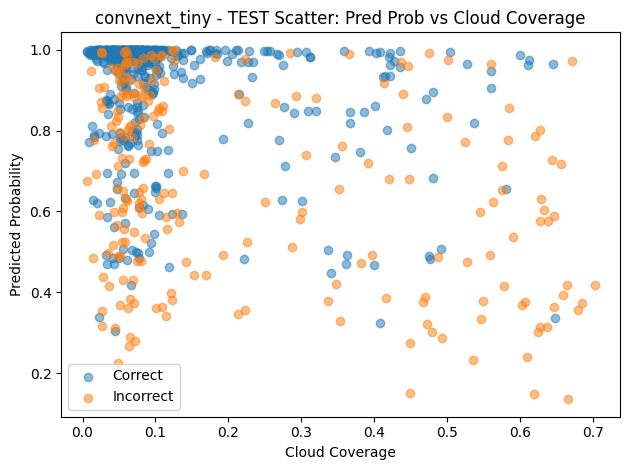

densenet121 TEST - Correct: avg pred_prob=0.8454, avg cloud_coverage=0.1124
densenet121 TEST - Incorrect: avg pred_prob=0.6193, avg cloud_coverage=0.2011


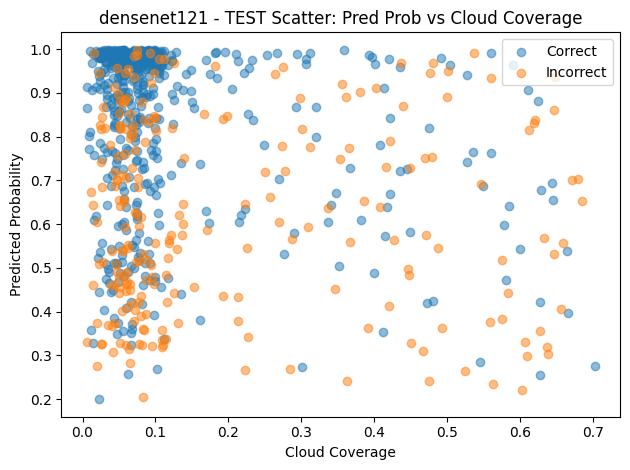

In [12]:
for split, ds_split in [('val', ds_val), ('test', ds_test)]:
    for name in MODEL_NAMES:
        csv_path = os.path.join('results', f"{split}_{name}_class_probs.csv")
        df = pd.read_csv(csv_path)

        # Predicted probability is the max over all class probabilities
        prob_cols = [c for c in df.columns if c.startswith('prob_')]
        df['pred_prob'] = df[prob_cols].max(axis=1)

        # Extract image quality and correctness
        qualities = [ds_split[i]['cloud_coverage'] for i in range(len(ds_split))]
        df['cloud_coverage'] = qualities
        df['correct'] = df['true'] == df['pred']

        # Compute and print average stats
        mask = df['correct']
        mean_pred_correct = df.loc[mask, 'pred_prob'].mean()
        mean_pred_incorrect = df.loc[~mask, 'pred_prob'].mean()
        mean_qual_correct = df.loc[mask, 'cloud_coverage'].mean()
        mean_qual_incorrect = df.loc[~mask, 'cloud_coverage'].mean()
        print(f"{name} {split.upper()} - Correct: avg pred_prob={mean_pred_correct:.4f}, avg cloud_coverage={mean_qual_correct:.4f}")
        print(f"{name} {split.upper()} - Incorrect: avg pred_prob={mean_pred_incorrect:.4f}, avg cloud_coverage={mean_qual_incorrect:.4f}")

        # Plot and save scatter with color coding
        plt.figure()
        # Correctly classified samples
        mask = df['correct']
        plt.scatter(df.loc[mask, 'cloud_coverage'],
                    df.loc[mask, 'pred_prob'],
                    alpha=0.5, label='Correct')
        # Misclassified samples
        plt.scatter(df.loc[~mask, 'cloud_coverage'],
                    df.loc[~mask, 'pred_prob'],
                    alpha=0.5, label='Incorrect')

        plt.title(f"{name} - {split.upper()} Scatter: Pred Prob vs Cloud Coverage")
        plt.xlabel('Cloud Coverage')
        plt.ylabel('Predicted Probability')
        plt.legend()
        plt.tight_layout()

        svg_path = os.path.join('results', f"{name}_{split}_scatter.svg")
        plt.savefig(svg_path, format='svg')
        plt.show()

In [13]:
# == Class-wise Correctness and Quality Analysis ==
for split, ds_split in [('val', ds_val), ('test', ds_test)]:
    for name in MODEL_NAMES:
        print(f"=== {name} {split.upper()} Class-wise Stats ===")
        csv_path = os.path.join('results', f"{split}_{name}_class_probs.csv")
        df = pd.read_csv(csv_path)
        prob_cols = [c for c in df.columns if c.startswith('prob_')]
        df['pred_prob'] = df[prob_cols].max(axis=1)
        df['true_class'] = df['true']
        # Add image quality and correctness
        df['cloud_coverage'] = [ds_split[i]['cloud_coverage'] for i in range(len(ds_split))]
        df['correct'] = df['true'] == df['pred']

        # Iterate over each class
        for class_idx, class_name in label_map.items():
            df_class = df[df['true_class'] == class_idx]
            n_samples = len(df_class)
            n_correct = df_class['correct'].sum()
            n_incorrect = n_samples - n_correct
            if n_samples == 0:
                continue
            mask = df_class['correct']
            mean_pred_corr = df_class.loc[mask, 'pred_prob'].mean()
            mean_pred_inc = df_class.loc[~mask, 'pred_prob'].mean()
            mean_qual_corr = df_class.loc[mask, 'cloud_coverage'].mean()
            mean_qual_inc = df_class.loc[~mask, 'cloud_coverage'].mean()
            print(f"Class {class_name} (idx {class_idx}):")
            print(f"  Samples: {n_samples} | Correct: {n_correct} | Incorrect: {n_incorrect}")
            print(f"  Correct  -> avg pred_prob={mean_pred_corr:.4f}, avg cloud_coverage={mean_qual_corr:.4f}")
            print(f"  Incorrect-> avg pred_prob={mean_pred_inc:.4f}, avg cloud_coverage={mean_qual_inc:.4f}")
        print("\n")

=== resnet50 VAL Class-wise Stats ===
Class Non-ship (idx 0):
  Samples: 97 | Correct: 83 | Incorrect: 14
  Correct  -> avg pred_prob=0.8874, avg cloud_coverage=0.1401
  Incorrect-> avg pred_prob=0.6376, avg cloud_coverage=0.2384
Class Aircraft carrier (idx 1):
  Samples: 33 | Correct: 27 | Incorrect: 6
  Correct  -> avg pred_prob=0.9572, avg cloud_coverage=0.0744
  Incorrect-> avg pred_prob=0.4721, avg cloud_coverage=0.1190
Class Submarine (idx 2):
  Samples: 48 | Correct: 34 | Incorrect: 14
  Correct  -> avg pred_prob=0.8580, avg cloud_coverage=0.0958
  Incorrect-> avg pred_prob=0.6187, avg cloud_coverage=0.2340
Class Medical ship (idx 3):
  Samples: 5 | Correct: 3 | Incorrect: 2
  Correct  -> avg pred_prob=0.7110, avg cloud_coverage=0.1152
  Incorrect-> avg pred_prob=0.4687, avg cloud_coverage=0.0503
Class Combat boat (idx 4):
  Samples: 29 | Correct: 21 | Incorrect: 8
  Correct  -> avg pred_prob=0.8414, avg cloud_coverage=0.0974
  Incorrect-> avg pred_prob=0.4322, avg cloud_coverag

In [14]:
# Prepare DataLoaders for cloud‐coverage regression
def collate_reg(batch):
    imgs = torch.stack([TRANSFORM(ex["image"].convert("RGB")) for ex in batch]).to(DEVICE)
    targets = torch.tensor([ex["cloud_coverage"] for ex in batch],
                           dtype=torch.float32, device=DEVICE).unsqueeze(1)
    return imgs, targets

train_reg_loader = DataLoader(
    ds_train, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, collate_fn=collate_reg
)
val_reg_loader = DataLoader(
    ds_val, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_reg
)
test_reg_loader = DataLoader(
    ds_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_reg
)

In [15]:
# Define a ResNet‐based regressor
regressor = models.resnet18(pretrained=True)
in_features = regressor.fc.in_features
regressor.fc = nn.Sequential(
    nn.Linear(in_features, 1),
    nn.Sigmoid()  # ensure outputs in [0,1]
)
regressor = regressor.to(DEVICE)

In [17]:
reg_criterion = nn.MSELoss()
reg_optimizer = optim.Adam(regressor.parameters(), lr=LEARNING_RATE)
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    # train
    regressor.train()
    running_loss = 0.0
    train_iter = tqdm(train_reg_loader, desc=f"Regressor Train Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    for imgs, targets in train_iter:
        reg_optimizer.zero_grad()
        outputs = regressor(imgs)
        loss = reg_criterion(outputs, targets)
        loss.backward()
        reg_optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(ds_train)

    # validate
    regressor.eval()
    running_val = 0.0
    preds_val, trues_val = [], []
    val_iter = tqdm(val_reg_loader, desc=f"Regressor Val Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    with torch.no_grad():
        for imgs, targets in val_iter:
            outputs = regressor(imgs)
            running_val += reg_criterion(outputs, targets).item() * imgs.size(0)
            preds_val.extend(outputs.cpu().squeeze().tolist())
            trues_val.extend(targets.cpu().squeeze().tolist())
    val_loss = running_val / len(ds_val)

    print(f"Epoch {epoch}/{NUM_EPOCHS}: Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(regressor.state_dict(), os.path.join("models", "quality_regressor.pth"))
        best_preds_val, best_trues_val = preds_val, trues_val

Epoch 1/10: Train MSE=0.0034, Val MSE=0.0025


Epoch 2/10: Train MSE=0.0023, Val MSE=0.0014


Epoch 3/10: Train MSE=0.0015, Val MSE=0.0012


Epoch 4/10: Train MSE=0.0009, Val MSE=0.0010


Epoch 5/10: Train MSE=0.0008, Val MSE=0.0008


Epoch 6/10: Train MSE=0.0006, Val MSE=0.0009


Epoch 7/10: Train MSE=0.0005, Val MSE=0.0009


Epoch 8/10: Train MSE=0.0005, Val MSE=0.0007


Epoch 9/10: Train MSE=0.0005, Val MSE=0.0008


Epoch 10/10: Train MSE=0.0004, Val MSE=0.0009


Test MSE=0.0007


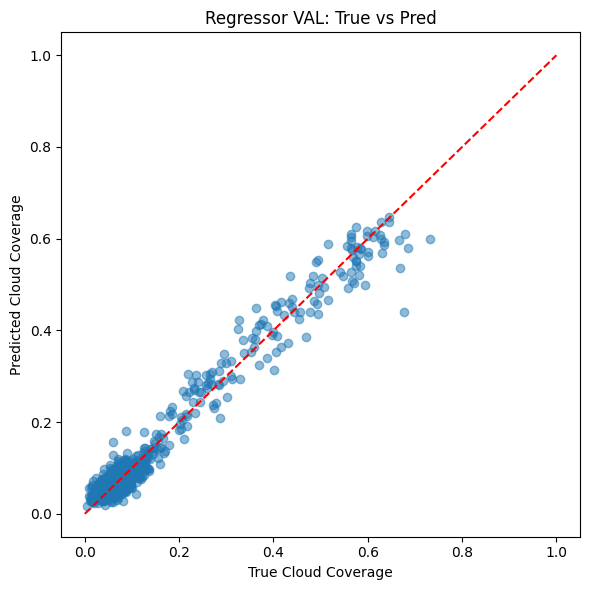

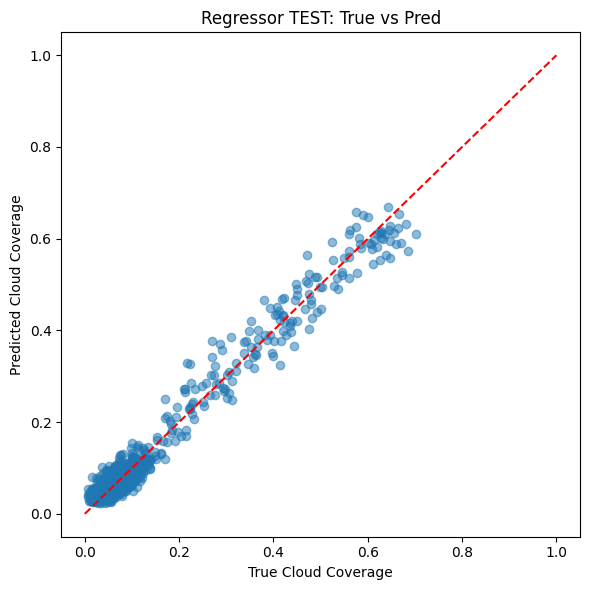

In [18]:
# test
regressor.load_state_dict(torch.load(os.path.join("models", "quality_regressor.pth"),
                   map_location=DEVICE))
regressor.eval()
running_test = 0.0
preds_test, trues_test = [], []

# Progress bar for testing
test_iter = tqdm(test_reg_loader, desc="Regressor Testing", leave=False)
with torch.no_grad():
  for imgs, targets in test_iter:
    outputs = regressor(imgs)
    running_test += reg_criterion(outputs, targets).item() * imgs.size(0)
    preds_test.extend(outputs.cpu().squeeze().tolist())
    trues_test.extend(targets.cpu().squeeze().tolist())

test_loss = running_test / len(ds_test)
print(f"Test MSE={test_loss:.4f}")

# save predictions
pd.DataFrame({"true": best_trues_val, "pred": best_preds_val}) \
  .to_csv(os.path.join("results", "regression_val_preds.csv"), index=False)
pd.DataFrame({"true": trues_test, "pred": preds_test}) \
  .to_csv(os.path.join("results", "regression_test_preds.csv"), index=False)

# scatter plots: true vs pred
for split, trues, preds in [
  ("val", best_trues_val, best_preds_val),
  ("test", trues_test, preds_test)
]:
  plt.figure(figsize=(6,6))
  plt.scatter(trues, preds, alpha=0.5)
  plt.plot([0,1],[0,1], 'r--')
  plt.xlabel("True Cloud Coverage")
  plt.ylabel("Predicted Cloud Coverage")
  plt.title(f"Regressor {split.upper()}: True vs Pred")
  plt.tight_layout()
  plt.savefig(os.path.join("results", f"regression_{split}_scatter.svg"), format="svg")
  plt.show()

In [ ]:
# Train and Evaluate Models with Regularization and Save Results and Model to Disk
# Inspect Results with Regularization
# TODO maybe I dont need this because models are already calibrated enough! But defintely needs then to go into future work part!

In [ ]:
# Global Conformal Prediction
# Our Conformal Prediction Quality-Bucket-Based Method

In [ ]:
# Ablation Studies Combinations:
# - ResNet18, MobileNetV3, EfficientNetB0
# - Regularization/Quality Scores: With, Without
# - Conformal Prediction: Global, Quality-Bucket-Based